# Set the Working Directory

In [1]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


# Load Libraries

In [2]:
import elapid as ela
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray as rxr
from sdm.geo import generate_model_raster
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from elapid import MaxentModel, GeographicKFold, distance_weights
from sdm.maxent import prepare_occurence_data, filter_bats, extract_split, cv_maxent, train_maxent, filter_gdf_to_grid
from sdm.config import latin_name, activity_type, genus
from sdm.geo import model_point_grid

from pathlib import Path

from sdm.features import load_evs, interpolate_nas, calculate_multiscale_variables

# Grid

I only want to keep one point for each species in each 100m grid square. I'm going to do this by loading the model raster which is a null raster which all the predictors are modelled on. I'll convert it to a geodataframe and then take the inner spatial join between the nearest points with a threshold of 100m.

In [3]:
grid_points = model_point_grid()

grid_points.head()


/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/pygeos/constructive.py:175: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


,geometry
0,POINT (403914.879 426796.146)
1,POINT (404014.948 426796.146)
2,POINT (404115.017 426796.146)
3,POINT (404215.086 426796.146)
4,POINT (404315.154 426796.146)


# Bat Records & Background Points


In [4]:
bats = gpd.read_parquet('data/processed/sybg-bats.parquet')
bats.head()

,grid_reference,species_raw,activity_type,source_data,date,latin_name,common_name,genus,x,y,accuracy,geometry,grid_square_geom
0,NZ115084,Common pipistrelle,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1274054400000,""Gr...",2010-05-17 00:00:00,Pipistrellus pipistrellus,Common Pipistrelle,Pipistrellus,411550.0,508450.0,100.0,POINT (411550.000 508450.000),"POLYGON ((411600.000 508400.000, 411600.000 50..."
1,NZ14640021,Pipistrellus sp.,Unknown,"{""Recorder"":""Giles Manners"",""Date"":14043456000...",2014-07-03 00:00:00,Pipistrellus sp.,Unidentified Pipistrelle,Pipistrellus,414645.0,500215.0,10.0,POINT (414645.000 500215.000),"POLYGON ((414650.000 500210.000, 414650.000 50..."
2,NZ20291106,Soprano pipistrelle,Unknown,"{""Recorder"":""Natural England Volunteer Bat Roo...",2013-11-28 00:00:00,Pipistrellus pygmaeus,Soprano Pipistrelle,Pipistrellus,420295.0,511065.0,10.0,POINT (420295.000 511065.000),"POLYGON ((420300.000 511060.000, 420300.000 51..."
3,NZ170014,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1283212800000,""Gr...",2010-08-31 00:00:00,Unknown,Unidentified Bat,Unknown,417050.0,501450.0,100.0,POINT (417050.000 501450.000),"POLYGON ((417100.000 501400.000, 417100.000 50..."
4,NZ185116,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1242777600000,""Gr...",2009-05-20 00:00:00,Unknown,Unidentified Bat,Unknown,418550.0,511650.0,100.0,POINT (418550.000 511650.000),"POLYGON ((418600.000 511600.000, 418600.000 51..."


In [5]:
bats = bats[bats.accuracy <= 100]

This function will be used once the data has been filtered to the right combination of species and behaviour to keep only the records which are unique to each 100m grid square.

In [6]:
background = gpd.read_parquet('data/processed/background-points.parquet')
background = background[["geometry"]]
background.head()

,geometry
95521,POINT (464074.488 382522.288)
203026,POINT (456961.158 396213.611)
294400,POINT (418755.227 407822.197)
404062,POINT (469163.850 421586.507)
17918,POINT (455529.697 372778.660)


I'm going to build a series of models based upon different taxonomic and behaviour classifications. I will build a model for:
- Each species and any behaviour type
- Each species and roosting or foraging
- Each genus and any behaviour type
- Each genus and roosting or foraging

# Environmental Variables

In [7]:
ev_folder = Path("data/evs/")
evs = load_evs(ev_folder)
evs

<xarray.Dataset>
Dimensions:                                         (y: 563, x: 792)
Coordinates:
  * x                                               (x) float64 4.039e+05 ......
  * y                                               (y) float64 4.268e+05 ......
    spatial_ref                                     int64 0
Data variables: (12/97)
    climate_stats_temp_ann_var                      (y, x) float64 ...
    climate_stats_temp_ann_avg                      (y, x) float64 ...
    climate_stats_temp_mat_avg                      (y, x) float64 ...
    climate_stats_prec_ann_var                      (y, x) float64 ...
    climate_stats_prec_ann_avg                      (y, x) float64 ...
    climate_stats_wind_ann_var                      (y, x) float64 ...
    ...                                              ...
    ceh-land-cover-100m_Upland Heathland            (y, x) float64 ...
    ceh-land-cover-100m_Wetland                     (y, x) float64 ...
    dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation  (y, x) float32 ...
    veg-height-100m_veg_height_mean                 (y, x) float32 ...
    veg-height-100m_veg_height_std                  (y, x) float32 ...
    veg-height-100m_veg_height_max                  (y, x) float32 ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('temp_ann_var', 'temp_ann_avg', 'temp_mat_avg', 'prec_an...

Many of the environmental variables are highly correlated with each other so I will only use a subset in the modelling

In [8]:
keep_evs = [
    "climate_stats_wind_ann_avg",
    "dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation",
    "climate_stats_temp_ann_avg",
    "climate_stats_prec_ann_avg",
    "bioclim_bioclim_15",
    "os-distance-to-feature_distance_to_buildings",
    "terrain-stats_slope",
    "terrain-stats_twi",
    "bioclim_bioclim_9",
    "ceh-land-cover-100m_Arable",
    "ceh-land-cover-100m_Improved grassland",
    "veg-height-100m_veg_height_max",
    "os-feature-cover-100m_water",
    "terrain-stats_aspect_northness_slope",
    "terrain-stats_aspect_eastness_slope",
    "terrain-stats_tpi",
    "ceh-land-cover-100m_Wetland",
    "os-feature-cover-100m_major_roads",
    "ceh-land-cover-100m_Upland Heathland",
    "ceh-land-cover-100m_Suburban",
    "ceh-land-cover-100m_Grassland",
    "os-distance-to-feature_distance_to_major_roads",
    "ceh-land-cover-100m_Urban",
    "os-distance-to-feature_distance_to_water",
    "ceh-land-cover-100m_Coniferous woodland",
]

In [9]:
# Subset the xr dataset to  only include the variables with the keep evs names
evs_to_model = evs[keep_evs]
evs_to_model

<xarray.Dataset>
Dimensions:                                         (y: 563, x: 792)
Coordinates:
  * x                                               (x) float64 4.039e+05 ......
  * y                                               (y) float64 4.268e+05 ......
    spatial_ref                                     int64 0
Data variables: (12/25)
    climate_stats_wind_ann_avg                      (y, x) float64 ...
    dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation  (y, x) float32 ...
    climate_stats_temp_ann_avg                      (y, x) float64 ...
    climate_stats_prec_ann_avg                      (y, x) float64 ...
    bioclim_bioclim_15                              (y, x) float32 ...
    os-distance-to-feature_distance_to_buildings    (y, x) float64 ...
    ...                                              ...
    ceh-land-cover-100m_Suburban                    (y, x) float64 ...
    ceh-land-cover-100m_Grassland                   (y, x) float64 ...
    os-distance-to-feature_distance_to_major_roads  (y, x) float64 ...
    ceh-land-cover-100m_Urban                       (y, x) float64 ...
    os-distance-to-feature_distance_to_water        (y, x) float64 ...
    ceh-land-cover-100m_Coniferous woodland         (y, x) float64 ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('temp_ann_var', 'temp_ann_avg', 'temp_mat_avg', 'prec_an...

## Focal Stats

In [10]:
evs_to_model = interpolate_nas(evs_to_model)

In [11]:


resolution = 100  # m
windows = [10] # 300m, 500m, 1000m

multiscale_variables = [
    "ceh-land-cover-100m_Arable",
    "veg-height-100m_veg_height_max",
    "os-feature-cover-100m_water",
    "ceh-land-cover-100m_Grassland",
    "ceh-land-cover-100m_Wetland",
    "ceh-land-cover-100m_Suburban",
    "ceh-land-cover-100m_Urban",
    "ceh-land-cover-100m_Improved grassland",
    "ceh-land-cover-100m_Coniferous woodland",
]

# Check the variable exists in the dataset
assert all([var in evs_to_model.data_vars for var in multiscale_variables])

# Calculate the average for each variable within the focal window
# and add the variable name as a suffix


# Calculate the multiscale variables for each window size
multiscale_datasets = [calculate_multiscale_variables(evs_to_model[multiscale_variables], window) for window in windows]
multiscale_datasets = xr.merge(multiscale_datasets)

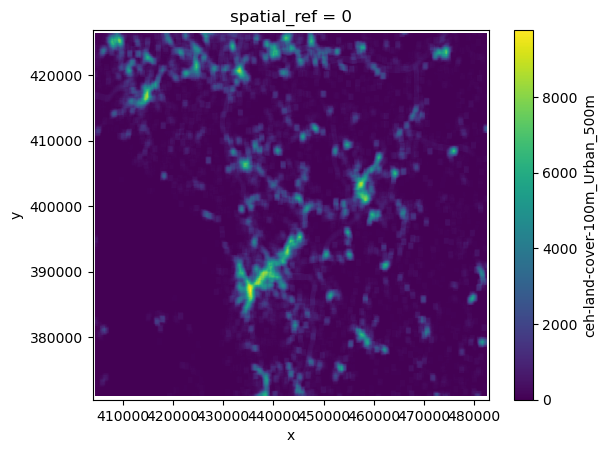

In [12]:
multiscale_datasets["ceh-land-cover-100m_Urban_500m"].plot()

In [13]:
## Add them to the evs
evs_multiscale = xr.merge([evs_to_model, multiscale_datasets])

## Point Annotation

In [14]:
## Annotate points
from tempfile import NamedTemporaryFile
ev_raster =  Path("data/sdm_predictions/evs.tif")
# Write the EVs to a temporary file and annotate the background and presence points

evs_multiscale.rio.to_raster(ev_raster)


ev_columns = list(evs_multiscale.data_vars.keys())
bats_ant = ela.annotate(
    bats, 
    ev_raster, 
    labels = ev_columns,
)
background = ela.annotate(
    background, 
    ev_raster, 
    labels = ev_columns,
)

Raster:   0%|                              | 0/1 [00:00<?, ?it/s]

Sample:   0%|                              | 0/9338 [00:00<?, ?it/s]

Raster:   0%|                              | 0/1 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

In [15]:
bats_ant.head()

,grid_reference,species_raw,activity_type,source_data,date,latin_name,common_name,genus,x,y,...,ceh-land-cover-100m_Coniferous woodland,ceh-land-cover-100m_Arable_500m,veg-height-100m_veg_height_max_500m,os-feature-cover-100m_water_500m,ceh-land-cover-100m_Grassland_500m,ceh-land-cover-100m_Wetland_500m,ceh-land-cover-100m_Suburban_500m,ceh-land-cover-100m_Urban_500m,ceh-land-cover-100m_Improved grassland_500m,ceh-land-cover-100m_Coniferous woodland_500m
0,NZ115084,Common pipistrelle,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1274054400000,""Gr...",2010-05-17 00:00:00,Pipistrellus pipistrellus,Common Pipistrelle,Pipistrellus,411550.0,508450.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NZ14640021,Pipistrellus sp.,Unknown,"{""Recorder"":""Giles Manners"",""Date"":14043456000...",2014-07-03 00:00:00,Pipistrellus sp.,Unidentified Pipistrelle,Pipistrellus,414645.0,500215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NZ20291106,Soprano pipistrelle,Unknown,"{""Recorder"":""Natural England Volunteer Bat Roo...",2013-11-28 00:00:00,Pipistrellus pygmaeus,Soprano Pipistrelle,Pipistrellus,420295.0,511065.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NZ170014,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1283212800000,""Gr...",2010-08-31 00:00:00,Unknown,Unidentified Bat,Unknown,417050.0,501450.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NZ185116,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1242777600000,""Gr...",2009-05-20 00:00:00,Unknown,Unidentified Bat,Unknown,418550.0,511650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling

Modelling process:
1. Filter to the species and behaviour type
2. Get the unique points in each 100m grid square
3. Calculate the distance weights for the points
4. Define the model and fit using Cross Validation
5. Save the model

In [16]:
ela.MaxentModel().get_params()

{'beta_categorical': 1.0,
 'beta_hinge': 1.0,
 'beta_lqp': 1.0,
 'beta_multiplier': 1.5,
 'beta_threshold': 1.0,
 'clamp': True,
 'class_weights': 100,
 'convergence_tolerance': 2e-06,
 'feature_types': ['linear', 'hinge', 'product'],
 'n_cpus': 10,
 'n_hinge_features': 10,
 'n_lambdas': 100,
 'n_threshold_features': 10,
 'scorer': 'roc_auc',
 'tau': 0.5,
 'transform': 'cloglog',
 'use_lambdas': 'best',
 'use_sklearn': True}

In [17]:
def maxent_model(n_jobs=1) -> Pipeline:
    model = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "maxent",
                MaxentModel(
                    feature_types=["linear", "hinge", "product"],
                    beta_multiplier=6,
                    n_cpus=n_jobs,
                    class_weights="balanced",
                ),
            ),
        ]
    )
    return model

In [18]:
# Generate every combination of latin name and activity type
from itertools import product

# Generate all combinations of latin name and activity type
filter_combinations = list(product(latin_name, activity_type))

In [19]:
training_data = []
for latin_name, activity_type in filter_combinations:
    presence = filter_bats(bats_ant, latin_name=latin_name, activity_type=activity_type)

    if len(presence) < 15:
        continue

    occurrence = prepare_occurence_data(
        presence, background, grid_points, input_vars=ev_columns
    )
    training_data.append({
        "latin_name": latin_name,
        "activity_type": activity_type,
        "occurrence": occurrence,
    })

In [20]:
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import as_completed
from sdm.maxent import eval_train_model
import pandas as pd
from tqdm import tqdm

# Get the number of cpus
import multiprocessing

num_cpus = multiprocessing.cpu_count()

executor = ProcessPoolExecutor(num_cpus)

# Submit tasks to the executor
futures = [
    executor.submit(eval_train_model, data["occurrence"], maxent_model())
    for data in training_data
]

# Collect results as they complete in the same order as submitted
results = [future.result() for future in tqdm(futures, total=len(futures)) if future.result() is not None]

100%|██████████| 25/25 [01:09<00:00,  2.79s/it]


### Prepare the results dataframe

In [21]:
import numpy as np

# Convert the inputs and outputs to a dataframe
modelling_df = pd.DataFrame(
    [
        {
            "final_model": final_model,
            "cv_models": cv_models,
            "cv_scores": np.array(cv_scores),
        }
        for final_model, cv_models, cv_scores in results
    ]
)
inputs_df = pd.DataFrame(training_data)
# Combin them
results_df = pd.concat([inputs_df, modelling_df], axis=1)

# Mutate some columns
def count_presence(occurrence):
    return (occurrence["class"] == 1).sum()
def count_background(occurrence):
    return (occurrence["class"] == 0).sum()

results_df["n_presence"] = results_df.occurrence.apply(count_presence)
results_df["n_background"] = results_df.occurrence.apply(count_background)

results_df["mean_cv_score"] = results_df.cv_scores.apply(np.mean)
results_df["mean_cv_score"] = results_df["mean_cv_score"].round(3)
results_df["std_cv_score"] = results_df.cv_scores.apply(np.std)
results_df["std_cv_score"] = results_df["std_cv_score"].round(3)

results_df["folds"] = results_df.cv_scores.apply(len)


results_df["activity_type"] = results_df.activity_type.fillna("All")


In [22]:
results_df

,latin_name,activity_type,occurrence,final_model,cv_models,cv_scores,n_presence,n_background,mean_cv_score,std_cv_score,folds
0,Pipistrellus pipistrellus,Foraging,climate_stats_wind_ann_avg \ 0 ...,"(StandardScaler(), MaxentModel(beta_multiplier...","[(StandardScaler(), MaxentModel(beta_multiplie...","[0.7456004981589777, 0.8763386052058338, 0.697...",894,7546,0.773,0.075,3
1,Pipistrellus pipistrellus,Roost,climate_stats_wind_ann_avg \ 0 ...,"(StandardScaler(), MaxentModel(beta_multiplier...","[(StandardScaler(), MaxentModel(beta_multiplie...","[0.8378536266201395, 0.8144190368455075, 0.847...",266,7546,0.833,0.014,3
2,Pipistrellus pipistrellus,All,climate_stats_wind_ann_avg \ 0 ...,"(StandardScaler(), MaxentModel(beta_multiplier...","[(StandardScaler(), MaxentModel(beta_multiplie...","[0.8566186353573687, 0.7130921453253534, 0.816...",1345,7546,0.795,0.060,3
3,Pipistrellus pygmaeus,Foraging,climate_stats_wind_ann_avg \ 0 ...,"(StandardScaler(), MaxentModel(beta_multiplier...","[(StandardScaler(), MaxentModel(beta_multiplie...","[0.8128762332595293, 0.8346474953617811, 0.838...",166,7546,0.829,0.011,3
4,Pipistrellus pygmaeus,Roost,climate_stats_wind_ann_avg \ 0 ...,"(StandardScaler(), MaxentModel(beta_multiplier...","[(StandardScaler(), MaxentModel(beta_multiplie...","[0.8455983953643861, 0.8906756131420639, 0.867...",49,7546,0.868,0.018,3
5,Pipistrellus pygmaeus,All,climate_stats_wind_ann_avg \ 0 ...,"(StandardScaler(), MaxentModel(beta_multiplier...","[(StandardScaler(), MaxentModel(beta_multiplie...","[0.7600513440048324, 0.7754831670822943, 0.865...",247,7546,0.800,0.047,3
6,Plecotus auritus,Foraging,climate_stats_wind_ann_avg \ 0 ...,"(StandardScaler(), MaxentModel(beta_multiplier...","[(StandardScaler(), MaxentModel(beta_multiplie...","[0.8909688013136289, 0.8264053171116368, 0.849...",47,7546,0.856,0.027,3
7,Plecotus auritus,Roost,climate_stats_wind_ann_avg \ 0 ...,"(StandardScaler(), MaxentModel(beta_multiplier...","[(StandardScaler(), MaxentModel(beta_multiplie...","[0.8291511771995044, 0.6830936779517048, 0.864...",118,7546,0.792,0.079,3
8,Plecotus auritus,All,climate_stats_wind_ann_avg \ 0 ...,"(StandardScaler(), MaxentModel(beta_multiplier...","[(StandardScaler(), MaxentModel(beta_multiplie...","[0.7905615527595081, 0.7168750464097423, 0.850...",182,7546,0.786,0.055,3
9,Myotis mystacinus,Foraging,climate_stats_wind_ann_avg \ 0 ...,"(StandardScaler(), MaxentModel(beta_multiplier...","[(StandardScaler(), MaxentModel(beta_multiplie...","[0.3882621219395104, 0.4478571428571429, 0.858...",19,7546,0.565,0.209,3


# Make Predictions

In [23]:
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import as_completed
from pathlib import Path
# Iterate through the df and make predictions using the best model
# save each prediction to a tif named after the latin name and activity type

prediction_paths = []
# Define the arguments for each task
tasks = []
for _, row in results_df.iterrows():
    latin_name = row.latin_name
    activity_type = row.activity_type
    model = row.final_model
    path_predict = Path(f"data/sdm_predictions/{latin_name}_{activity_type}.tif")
    prediction_paths.append(path_predict)
    tasks.append({
        "model": model,
        "raster_paths": [ev_raster],
        "output_path": path_predict,
        "windowed": True,
    })
    
# Submit the tasks to the executor
executor = ProcessPoolExecutor()
futures = [executor.submit(ela.apply_model_to_rasters, **task) for task in tasks]

# Wait for the tasks to complete
# Use a progress bar to track progress
for future in tqdm(as_completed(futures), total=len(futures)):
    pass


100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


In [24]:
results_df["prediction_path"] = prediction_paths

In [25]:
# ML Flow logging
import mlflow
from mlflow import log_metric, log_param, log_params, log_artifacts, log_artifact
import json
input_var_json_path = 'models/input_variables.json'

with open(input_var_json_path, 'w') as f:
    json.dump(ev_columns, f)

mlflow.set_experiment("Sheffield Bat Group - SDM - Maxent")


# Iterate over the results dataframe to log models, parameters and metrics

for _, row in tqdm(results_df.iterrows()):
    with mlflow.start_run(run_name = f"Model_{row['latin_name']}_{row['activity_type']}"):
        mlflow.set_tag("model", "Maxent")
        # Generate a species code from the first 3 letters of the genus and species
        # This makes it easier to identify the species in mlflow
        genus = row["latin_name"].split(" ")[0]
        species = row["latin_name"].split(" ")[1]
        species_code = genus[:3] + "_" + species[:3]
        mlflow.set_tag("species_code", species_code)

        mlflow.set_tag("latin_name", row["latin_name"])
        mlflow.set_tag("activity_type", row["activity_type"])
        # Log the parameters
        log_params(row[["n_presence", "n_background", "folds"]].to_dict())
        # Log model parameters
        log_params(row["final_model"].get_params())

        # Log the input variables which exceed the param length limit
        log_artifact(input_var_json_path, "input_variables")

        # Log the training data
        with NamedTemporaryFile(suffix = ".parquet") as f:
            occurence_gdf = row["occurrence"]
            occurence_gdf.to_parquet(f.name)
            log_artifact(f.name, "training_data")

        # Log the metrics
        log_metric("mean_cv_score", row["mean_cv_score"])
        log_metric("std_cv_score", row["std_cv_score"])

        # Log the predictions as an artifact
        log_artifact(row["prediction_path"], "predictions_raster")


        # Log the model
        mlflow.sklearn.log_model(row["final_model"], "model")



1it [00:02,  2.14s/it]/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2it [00:03,  1.87s/it]/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` mo

In [26]:
results_df.to_csv("data/sdm_predictions/results.csv", index=False)

# Pickle the results dataframe
results_df.to_pickle("data/sdm_predictions/results.pkl")

# Unnest the occurence dataframe and save as a parquet file

def extract_occurrence_df(row):
    row_occurrence = row["occurrence"]
    row_occurrence["latin_name"] = row["latin_name"]
    row_occurrence["activity_type"] = row["activity_type"]
    return row_occurrence

occurrence_gdf = pd.concat([extract_occurrence_df(row) for _, row in results_df.iterrows()])
occurrence_gdf.to_parquet("data/sdm_predictions/training-occurrence-data.parquet")


In [28]:
import leafmap
model_result = results_df.iloc[15]
selected_path = model_result.prediction_path

print(f"Mapping predictions for {selected_path.stem}. Accuracy: {model_result.mean_cv_score}")
m = leafmap.Map()
m.add_basemap("HYBRID")
m.add_raster(str(selected_path), layer_name = "Predictions", cmap = "viridis")
m.add_gdf(model_result.occurrence[model_result.occurrence["class"] == 1], layer_name = "Occurrence")

m

Mapping predictions for Myotis daubentonii_Foraging. Accuracy: 0.789


Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…